# Google Stock Price Prediction using RNNs

## Data Preprocessing

### Importing the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

### Importing the training set

In [3]:
df = pd.read_csv('Google_Stock_Price_Train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [5]:
train = df['Open'].values.reshape(-1, 1)

In [6]:
print(df.shape)
print(train.shape)

(1258, 6)
(1258, 1)


#### Visualising the data

<AxesSubplot:>

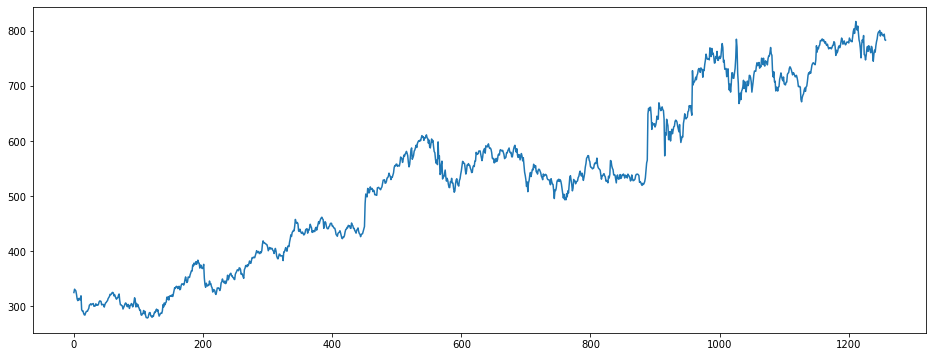

In [7]:
df['Open'].plot(figsize=(16,6))

### Feature Scaling

It is recommended to use Normalization for RNN models

In [8]:
sc = MinMaxScaler(feature_range=(0, 1))

In [9]:
train_scaled = sc.fit_transform(train)

In [10]:
print(train_scaled)

[[0.08581368]
 [0.09701243]
 [0.09433366]
 ...
 [0.95725128]
 [0.93796041]
 [0.93688146]]


### Creating a data structure with 60 timesteps and 1 output
At each time 'T', the RNN will look at 60 stock prices before time T
Since there are 20 financial days in a month, so ~3 months before time T

In [11]:
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(train_scaled[i-60:i, 0]) #0 to 59
    y_train.append(train_scaled[i, 0]) # 60(Since indexes start at 0)
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping
Reshape it to (batch size, timesteps, contributors/indicators)

In [22]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
print(y_train.shape)

(1198, 60, 1)
(1198,)


## Building and Training the RNN

### Initialising the RNN

In [13]:
rnn = Sequential()

### Adding the first LSTM layer and some Dropout regularisation
LSTM:- 50 units, since it is complex neural network, for input shape batch size is **automatically detected**
`return_sequences` is `True`, since we are adding another layer of LSTM after this
Dropout:- 20% of the neurons are ignored, 20% of 50 = 10 neurons in each iteration are ignored

In [14]:
rnn.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
rnn.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [15]:
rnn.add(LSTM(units= 50, return_sequences= True))
rnn.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [16]:
rnn.add(LSTM(units= 50, return_sequences= True))
rnn.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation
`return_sequences` is `False` since we are not returning any more sequences or adding any more LSTM layers

In [17]:
rnn.add(LSTM(units= 50))
rnn.add(Dropout(0.2))

### Adding the output layer
Output layer has only one dimension, the output, hence `units=1`

In [18]:
rnn.add(Dense(units= 1))

### Compiling the RNN

In [19]:
rnn.compile(optimizer= 'adam', loss= 'mean_squared_error')

### Fitting the RNN to the Training set
We may use any number of `epochs` but since the model starts to show convergence at `100`, I use it here.
`batch_size = 32`, since 32 is a very commonly used value for `batch_size`, again we may use any value as per our choice

In [20]:
rnn.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 12s 85ms/step - loss: 0.0373
Epoch 2/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0059
Epoch 3/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0056
Epoch 4/100
38/38 [==============================] - 3s 73ms/step - loss: 0.0050
Epoch 5/100
38/38 [==============================] - 3s 85ms/step - loss: 0.0045
Epoch 6/100
38/38 [==============================] - 3s 81ms/step - loss: 0.0051
Epoch 7/100
38/38 [==============================] - 3s 82ms/step - loss: 0.0045
Epoch 8/100
38/38 [==============================] - 3s 74ms/step - loss: 0.0055
Epoch 9/100
38/38 [==============================] - 3s 79ms/step - loss: 0.0057
Epoch 10/100
38/38 [==============================] - 3s 76ms/step - loss: 0.0042
Epoch 11/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0043
Epoch 12/100
38/38 [==============================] - 3s 73ms/step - loss: 0.0045
Epoch 13/100
38/38 [====

## Making the predictions and visualising the results

In [26]:
df_test = pd.read_csv('Google_Stock_Price_Test.csv')

<AxesSubplot:>

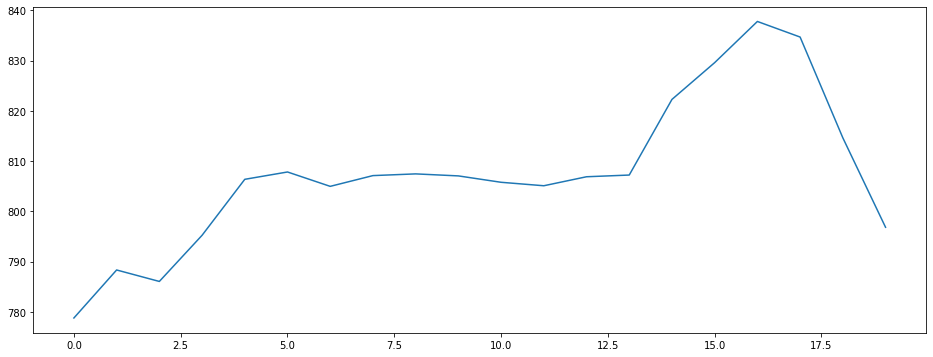

In [27]:
df_test['Open'].plot(figsize=(16,6))

In [41]:
test = df_test.Open.values

### Getting the real stock price of 2017

We need `[T-60, T]` days of stock prices to predict stock price at day `T+1`
**Instead of using already scaled values, we use the original values(unscaled), concatenate them with the `test` values and then scale it**, otherwise had we used the former method, we would be using `fit_transform` which would change the actual test values.
Since we don't use that, and we concatenate it with the original data and then scale it, the test data is unaffected.

### Concatenating testing and training datasets

In [34]:
full = pd.concat((df.Open, df_test.Open), axis= 0)
inputs = full[len(full) - len(df_test) - 60:].values

In [35]:
inputs = inputs.reshape(-1, 1)

#### Scaling the inputs

In [36]:
inputs = sc.transform(inputs)

#### Creating X_test and reshaping it to the 3D input

In [37]:
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test= np.array(X_test)

In [38]:
X_test= X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#### Predicting Values and Inversing the scaling

In [40]:
y_pred = rnn.predict(X_test)
y_pred = sc.inverse_transform(y_pred)

1/1 [==============================] - 0s 39ms/step


### Visualising the results

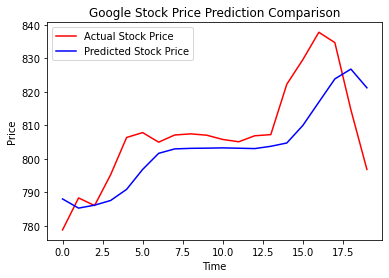

In [42]:
plt.plot(test, color='Red', label='Actual Stock Price')
plt.plot(y_pred, color='Blue', label='Predicted Stock Price')
plt.title('Google Stock Price Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [47]:
import math
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, y_pred)
print(f"The model has a root mean squared error of: {math.sqrt(mse)}")

The model has a root mean squared error of: 11.401982137802394
